
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=10>
    Deep Learning - HW4 <br>
<font color=2565AE size=5>
    Electrical Engineering Department <br>
    winter 2024<br>
<font color=3C99D size=5>
    Practical Assignment 2 <br>
<font color=696880 size=4>
    Armin Ghojehzadeh 

____

### **Student Information:**

- **Name:** Muhammad Erfan Bagherinejad
- **Student Number:** 402200359

In [2]:
!pip uninstall torchtext -y
!pip install --upgrade torch --index-url https://download.pytorch.org/whl/cu118
!pip install --upgrade torchdata
!pip install --upgrade torchtext --index-url https://download.pytorch.org/whl/cu118
!pip install torchmetrics

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.3/838.3 MB 2.0 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 5.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 63.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.6 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 9.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 2.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 13.5 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 8.4 MB/s eta 0:00:000:00:0100:01
     ━━━━━━━━━━━━━━━━━

# 🔴 **Import Libs**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchtext

import torch

import math

from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
from torch.nn import functional as F

import torchmetrics as tm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(0)

In [4]:
!python --version
print(torch.__version__)
print(torchtext.__version__)

Python 3.10.12
2.2.0+cu118
0.17.0+cpu


In [5]:
for lib in [np, torch, torchtext]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.2.0+cu118
torchtext --> 0.17.0+cpu


# 🔴 **Utils**

In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# 🔴 **Dataset**

## 🟠 **Load the Dataset**

🔰 In this session you should load WikiText2 dataset.

In [7]:
from datasets import load_dataset

dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
print(dataset)

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [8]:
sample_text = dataset['train'][90]['text']
for i, voc in enumerate(sample_text.split()):
    print(voc, end=" ")
    if i%20 == 19:
        print('')

Lt. Col. Dunnington 's " Returns for the month of August , 1862 , at Little Rock Arsenal , C.S.A. 
, " are found in Vol . 149 , Chapter IV of the " Captured Rebel Ordnance Records , " 
and are most enlightening as to the scope of Confederate ordnance activities at Little Rock during this crucial time . 
According to Dunnington , " When I assumed command at this Post , all material had been removed to Arkadelphia 
. There were no persons employed . No shops were open for repair of arms or for fabricating ammunition . 
Material , tools , etc . , had to be procured as well as the employment of laborers . Work 
commenced the last part of the month . " 

## 🟠 **Build vocabulary and save it**

🔰 In this section we need to:

*   Define a tokenizer using `basic_english`
*   Tokenize the dataset and collect tokens
*   Build the vocabulary using `build_vocab_from_iterator`
*   Manually insert special tokens and set the default index


In [9]:
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = torchtext.data.get_tokenizer('basic_english')
tokenize_data = lambda example, tokenizer: {'tokens': tokenizer(example['text'])}
tokenized_dataset = dataset.map(tokenize_data, remove_columns=['text'], fn_kwargs={'tokenizer': tokenizer})

sample_text = tokenized_dataset['train'][90]['tokens']
for i, voc in enumerate(sample_text):
    print(voc, end=" ")
    if i%20 == 19:
        print('')

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

lt . col . dunnington ' s returns for the month of august , 1862 , at little rock arsenal 
, c . s . a . , are found in vol . 149 , chapter iv of the captured 
rebel ordnance records , and are most enlightening as to the scope of confederate ordnance activities at little rock during 
this crucial time . according to dunnington , when i assumed command at this post , all material had been 
removed to arkadelphia . there were no persons employed . no shops were open for repair of arms or for 
fabricating ammunition . material , tools , etc . , had to be procured as well as the employment of 
laborers . work commenced the last part of the month . 

In [10]:
vocab = build_vocab_from_iterator(tokenized_dataset['train']['tokens'], min_freq=5) 
vocab.insert_token('<unk>', 0)           
vocab.insert_token('<eos>', 1)            
vocab.set_default_index(vocab['<unk>'])   
print(f'Vocab length is: {len(vocab)}')                         
print(vocab.get_itos()[:20])  # itos: index to string  

Vocab length is: 20923
['<unk>', '<eos>', 'the', ',', '.', 'of', 'and', 'in', 'to', 'a', '=', 'was', "'", '@-@', 'on', 'as', 's', 'that', 'for', 'with']


## 🟠 EDA

### 🟡 Let's explore the WikiText2 dataset!

### 🟡 Calculate basic statistics such as the number of documents, total words, average document length, etc.

In [11]:
print(dataset)
print(f"number of documents: {len(dataset['test'])+ len(dataset['validation'])+ len(dataset['train'])}")

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})
number of documents: 44836


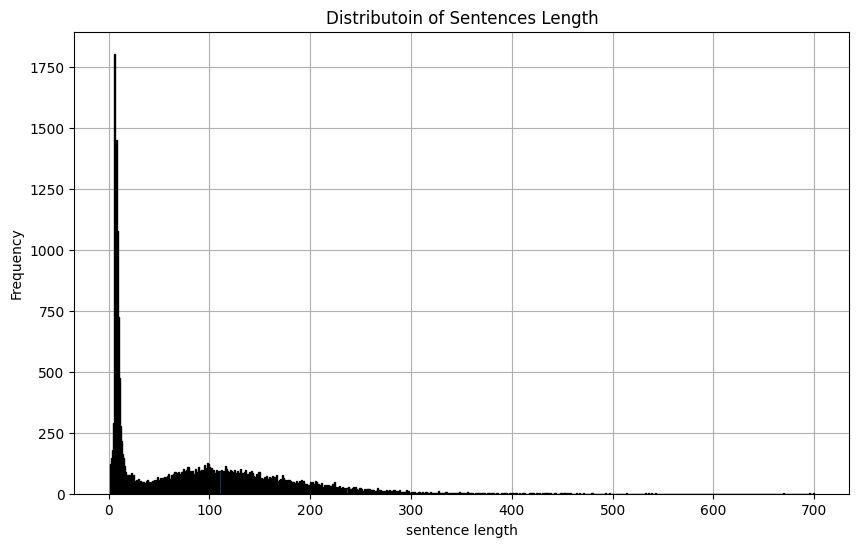

Total words: 2051910
Average document length: 55
99.9% of the sentences have 425 words.


In [12]:
sentences = dataset['train']['text']
word_count = [len(sentence.split()) for sentence in sentences]
# Plot the distribution of word counts
plt.figure(figsize=(10, 6))
plt.hist(word_count, 
         bins=range(1, max(word_count) + 2),
         zorder=2, 
         edgecolor='black')
plt.title('Distributoin of Sentences Length')
plt.xlabel('sentence length')
plt.ylabel('Frequency')
plt.grid()
plt.show()

print(f'Total words: {sum(word_count)}')
print(f'Average document length: {sum(word_count)//len(word_count)}')

p = 99.9
maximum_length = int(np.percentile(word_count, p))
print(f"{p}% of the sentences have {maximum_length} words.")

In [13]:
print(f'Vocab length is: {len(vocab)}')

Vocab length is: 20923


### 🟡 Analyze the most common and least common words in the dataset.

In [14]:
import pandas as pd
from collections import Counter

# Get the counts of tokens
token_counts = Counter(token for tokens in tokenized_dataset['train']['tokens'] for token in tokens)

# Find the most and least frequent tokens
most_frequent_tokens = token_counts.most_common(10)
least_frequent_tokens = [(token, count) for token, count in token_counts.items() if count < 5]

# Create DataFrames
most_frequent_df = pd.DataFrame(most_frequent_tokens, columns=['Token', 'Count'])
least_frequent_df = pd.DataFrame(least_frequent_tokens[:10], columns=['Token', 'Count'])

# Display DataFrames
print("Most Frequent Tokens:")
print(most_frequent_df)

print(f"\nLeast Frequent Tokens(<10): {len(least_frequent_tokens)}")
print(least_frequent_df)


Most Frequent Tokens:
  Token   Count
0   the  130770
1     ,  102624
2     .   84291
3    of   57032
4   and   50736
5    in   45018
6    to   39522
7     a   36564
8     =   29570
9   was   21008

Least Frequent Tokens(<10): 45136
         Token  Count
0   unrecorded      4
1  戦場のヴァルキュリア3      3
2      europan      3
3     calamaty      1
4    forgiving      1
5        raita      2
6       honjou      3
7      hitoshi      3
8        ozawa      3
9        azure      4


### 🟡  Please proceed with further exploration of the dataset. what do you suggest?

In [15]:
# I suggest distribution of sentences length.

## 🟠 Transform the data

🛑 Make sure to perform the transformations on train, validation and test datasets.

🔰 Reshape the dataset into an `N x B x L` or `M x L` format, where `N` represents the number of batches, `B` is the batch size, `L` is the length of a sample within each batch, and `M` is equal to `N x B`.

In [16]:
def get_data(dataset, vocab, batch_size):
    data = []                                                   
    for example in dataset:
        if example['tokens']:                                      
            tokens = example['tokens'].append('<eos>')             
            tokens = [vocab[token] for token in example['tokens']] 
            data.extend(tokens)                                    
    data = torch.LongTensor(data)                                 
    num_batches = data.shape[0] // batch_size 
    data = data[:num_batches * batch_size]                       
    data = data.view(batch_size, num_batches)          
    return data

In [17]:
batch_size = 128
train_data = get_data(tokenized_dataset['train'], vocab, batch_size)
valid_data = get_data(tokenized_dataset['validation'], vocab, batch_size)
test_data = get_data(tokenized_dataset['test'], vocab, batch_size)

In [18]:
print(train_data.shape)

torch.Size([128, 16214])


## 🟠 Custom dataset

🔰 Write a custom dataset class for LanguageModelDataset.

In [19]:
class LanguageModelDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len
        self.batch_size, self.total_seq_len = data.shape

        # Calculate number of splits (N) correctly
        self.num_splits = (self.total_seq_len + seq_len - 1) // seq_len

    def __len__(self):
        return self.num_splits

    def __getitem__(self, idx):
        if idx >= self.num_splits:
            raise IndexError("Index out of range")

        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len

        # Handle overlap for the last submatrix
        if end_idx > self.total_seq_len-1:
            end_idx = self.total_seq_len-1
            start_idx = max(0, end_idx - self.seq_len)

        inputs = self.data[:, start_idx:end_idx]
        targets = self.data[:, start_idx + 1:end_idx + 1]

        return inputs, targets


In [20]:
seq_len = 100

# Create dataset objects
train_dataset = LanguageModelDataset(train_data, seq_len)
valid_dataset = LanguageModelDataset(valid_data, seq_len)
test_dataset = LanguageModelDataset(test_data, seq_len)

inputs, targets = train_dataset[0]
print("Inputs:", inputs.shape)  # Should be [batch_size, seq_len]
print("Targets:", targets.shape)  # Should be [batch_size, seq_len]


Inputs: torch.Size([128, 100])
Targets: torch.Size([128, 100])


In [21]:
num_samples = len(train_dataset)
sample_data_shape = train_dataset[0][0].shape  # Shape of the first data sample
sample_target_shape = train_dataset[0][1].shape  # Shape of the first target sample

print(f"Number of samples: {num_samples}")
print(f"Sample data shape: {sample_data_shape}")    # Shape: [seq_len, feature_dim]
print(f"Sample target shape: {sample_target_shape}")  # Shape: [target_dim]

Number of samples: 163
Sample data shape: torch.Size([128, 100])
Sample target shape: torch.Size([128, 100])


In [22]:
print((train_dataset[162][1].shape))

torch.Size([128, 100])


## 🟠 Define a dataloader if needed

🔰 Write dataloaders for the training, validation, and test sets.
## we don't need that.

# 🔴 **Model**

🔰 Use the following template to create a custom model.

Your model should consist of three parts:

*   an embedding layer
*   an LSTM layer
*   a fully connected layer

In [5]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
        if tie_weights:
            assert embedding_dim == hidden_dim, 'embedding_dim must equal hidden_dim'
            self.embedding.weight = self.fc.weight
            
            
        self.init_weights()

    def forward(self, src, hidden):
        embedding = self.dropout(self.embedding(src))
        output, hidden = self.lstm(embedding, hidden)          
        output = self.dropout(output) 
        prediction = self.fc(output)
        return prediction, hidden

    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hidden_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_emb)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(self.embedding_dim, self.hidden_dim).uniform_(-init_range_other, init_range_other) 
            self.lstm.all_weights[i][1] = torch.FloatTensor(self.hidden_dim, self.hidden_dim).uniform_(-init_range_other, init_range_other) 

    def init_hidden(self, batch_size, device):
        hidden = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        cell = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden, cell

    # We don't need to learn the hidden state so we can detach it from the computation graph
    def detach_hidden(self, hidden):
        hidden, cell = hidden
        hidden = hidden.detach()
        cell = cell.detach()
        return hidden, cell

# 🔴 **Config**

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

🔰 Define the optimizer, loss function, metrics and other necessary parameters in this section, and ensure the model is sent to the appropriate device.

In [7]:
vocab_size = len(vocab)
embedding_dim = 1024            
hidden_dim = 1024                
num_layers = 2                   
dropout_rate = 0.65             
tie_weights = True                  

In [26]:
# Loss and optimizer
loss_fn = nn.CrossEntropyLoss().to(device)

class Perplexity(tm.Metric):
    def __init__(self):
        super().__init__()
        self.add_state("loss", default=torch.tensor(0.0), dist_reduce_fx="sum")  # Initialize as tensor
        self.add_state("count", default=torch.tensor(0.0), dist_reduce_fx="sum")  # Initialize as tensor

    def update(self, preds, targets):
        # Compute the loss
        loss = loss_fn(preds.view(-1, vocab_size), targets.view(-1))
        self.loss += loss * targets.size(0)  # Cumulative loss
        self.count += targets.size(0)  # Cumulative count of tokens

    def compute(self):
        return torch.exp(self.loss / self.count)  # Calculate perplexity

# Instantiate the perplexity metric
metric = Perplexity().to(device)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [27]:
def train(model, data_loader, loss_fn, optimizer, metric, device):
    epoch_loss = 0
    model.train()
    loss_train = AverageMeter()
    metric.reset()
    
    # Get batch size and sequence length from the first batch
    tmp, _ = next(iter(data_loader))
    batch_size = tmp.shape[0]
    seq_len = tmp.shape[1]

    hidden = model.init_hidden(batch_size, device)
    
    tepoch = tqdm(data_loader, desc="Training", leave=True)
    
    for data in tepoch: 
        inputs, targets = data
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)

        prediction, hidden = model(inputs, hidden)  
        prediction = prediction.reshape(batch_size * seq_len, -1)   
        target = targets.reshape(-1)
        loss = loss_fn(prediction, target)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
        
        optimizer.step()
        
        loss_train.update(loss.item(), n=len(targets))
        metric.update(prediction, targets) 
        
        epoch_loss += loss.item() * seq_len
        
        tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())
    
    return model, loss_train.avg, metric.compute().item()


# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [28]:
def evaluate(model, data_loader, loss_fn, metric):
    model.eval()
    loss_eval = AverageMeter()
    metric.reset()

    # Get batch size and sequence length from the first batch
    tmp, _ = next(iter(data_loader))
    batch_size = tmp.shape[0]
    seq_len = tmp.shape[1]

    hidden = model.init_hidden(batch_size, device)

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Evaluating", leave=True):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            hidden = model.detach_hidden(hidden)
            
            prediction, hidden = model(inputs, hidden)  
            prediction = prediction.reshape(batch_size * seq_len, -1)   
            target = targets.reshape(-1) 
            loss = loss_fn(prediction, target)
            
            loss_eval.update(loss.item(), n=len(targets))
            
            metric(prediction, targets)

    return loss_eval.avg, metric.compute().item()


# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [30]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
print(f"The number of learnable parameters: {num_trainable_params(model)}")

loss = 0
for i in range(20, 30):
  inputs, targets = ((train_dataset[i]))
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.no_grad():
    hidden = model.init_hidden(batch_size, device)
    prediction, hidden = model(inputs, hidden)  
    prediction = prediction.reshape(batch_size * seq_len, -1)   
    target = targets.reshape(-1)
    loss += loss_fn(prediction, target)
loss = loss/10

print(loss)

The number of learnable parameters: 38.239675
tensor(9.9488, device='cuda:0')


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [42]:
from torch.utils.data import Subset

# Create a subset with the first 20 elements
mini_dataset = Subset(train_dataset, list(range(20)))
print(len(mini_dataset))
print(mini_dataset[0][0].shape)

20
torch.Size([128, 50])


In [65]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for i in range(20):
    _, l, met = train(model, mini_dataset, loss_fn, optimizer, metric, device)
    print(f'epoch: {i+1}, loss:{l}, metrics:{met}')

Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.38, metric=218]


epoch: 1, loss:5.382934594154358, metrics:217.66017150878906


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.32, metric=204]


epoch: 2, loss:5.316346430778504, metrics:203.63856506347656


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.3, metric=200] 


epoch: 3, loss:5.297313380241394, metrics:199.7992706298828


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.25, metric=191]


epoch: 4, loss:5.250675868988037, metrics:190.69515991210938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=5.19, metric=180]


epoch: 5, loss:5.193962097167969, metrics:180.1810302734375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.14, metric=171]


epoch: 6, loss:5.143066453933716, metrics:171.24014282226562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=5.1, metric=163] 


epoch: 7, loss:5.0968122482299805, metrics:163.49996948242188


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.05, metric=156]


epoch: 8, loss:5.050406146049499, metrics:156.0858154296875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=5.01, metric=150]


epoch: 9, loss:5.011225342750549, metrics:150.08843994140625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=4.99, metric=147]


epoch: 10, loss:4.99156813621521, metrics:147.16702270507812


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.94, metric=139]


epoch: 11, loss:4.937210106849671, metrics:139.38084411621094


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=4.87, metric=130]


epoch: 12, loss:4.869126772880554, metrics:130.2071075439453


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=4.82, metric=124]


epoch: 13, loss:4.8175455808639525, metrics:123.66123962402344


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.78, metric=119]


epoch: 14, loss:4.7756987571716305, metrics:118.5931396484375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.76, metric=117]


epoch: 15, loss:4.760961866378784, metrics:116.85834503173828


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.7, metric=110] 


epoch: 16, loss:4.699635100364685, metrics:109.90705871582031


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.69, metric=109]


epoch: 17, loss:4.691473150253296, metrics:109.01374816894531


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=4.74, metric=114]


epoch: 18, loss:4.73622727394104, metrics:114.00326538085938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=4.64, metric=104]


epoch: 19, loss:4.6412618398666385, metrics:103.67510986328125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=4.6, metric=99.7]

epoch: 20, loss:4.602403235435486, metrics:99.72372436523438


### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [67]:
num_epochs = 5

for lr in [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]:
    print(f'LR={lr}')

    model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    for epoch in range(num_epochs):
        model, l, met = train(model, mini_dataset, loss_fn, optimizer, metric, device)
        print(f'epoch: {epoch+1}, loss:{l}, metrics:{met}')

    print("=="*50)



LR=0.05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=29.6, metric=7.15e+12]


epoch: 1, loss:29.598110461235045, metrics:7149820313600.0


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=9.84, metric=1.88e+4]


epoch: 2, loss:9.84373779296875, metrics:18840.001953125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=8.1, metric=3.29e+3] 


epoch: 3, loss:8.098400378227234, metrics:3289.204833984375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=8.21, metric=3.69e+3]


epoch: 4, loss:8.214134621620179, metrics:3692.781494140625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=7.86, metric=2.59e+3]


epoch: 5, loss:7.85893189907074, metrics:2588.7529296875
LR=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=8.23, metric=3.77e+3]


epoch: 1, loss:8.233897686004639, metrics:3766.487548828125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.11, metric=1.23e+3]


epoch: 2, loss:7.111076164245605, metrics:1225.4658203125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.1, metric=1.21e+3] 


epoch: 3, loss:7.0961603879928585, metrics:1207.3231201171875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=7.02, metric=1.11e+3]


epoch: 4, loss:7.015224432945251, metrics:1113.45556640625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=7.21, metric=1.35e+3]


epoch: 5, loss:7.209784054756165, metrics:1352.598876953125
LR=0.005


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=7.63, metric=2.05e+3]


epoch: 1, loss:7.625461721420288, metrics:2049.728271484375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.96, metric=1.06e+3]


epoch: 2, loss:6.964343166351318, metrics:1058.219482421875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.95, metric=1.05e+3]


epoch: 3, loss:6.9549803018569945, metrics:1048.357421875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.87, metric=965]    


epoch: 4, loss:6.872219586372376, metrics:965.0891723632812


Training: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s, loss=6.68, metric=799]


epoch: 5, loss:6.683854389190674, metrics:799.3941040039062
LR=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=7.68, metric=2.17e+3]


epoch: 1, loss:7.684348750114441, metrics:2174.054443359375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.89, metric=980]    


epoch: 2, loss:6.8873412847518924, metrics:979.793212890625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.77, metric=875]


epoch: 3, loss:6.774737739562989, metrics:875.448974609375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.75, metric=853]


epoch: 4, loss:6.748709678649902, metrics:852.95703125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.74, metric=844]


epoch: 5, loss:6.737655067443848, metrics:843.5799560546875
LR=0.0005


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=8.05, metric=3.14e+3]


epoch: 1, loss:8.052850937843322, metrics:3142.744384765625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.9, metric=990]     


epoch: 2, loss:6.8973588943481445, metrics:989.657470703125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.79, metric=889]   


epoch: 3, loss:6.789812397956848, metrics:888.7470092773438


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.75, metric=855]


epoch: 4, loss:6.7508230924606325, metrics:854.7619018554688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.73, metric=841]


epoch: 5, loss:6.734981417655945, metrics:841.3280029296875
LR=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=9.85, metric=1.89e+4]


epoch: 1, loss:9.845714855194093, metrics:18877.302734375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.7, metric=2.22e+3] 


epoch: 2, loss:7.703554677963257, metrics:2216.2119140625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.97, metric=1.06e+3]


epoch: 3, loss:6.967798471450806, metrics:1061.8817138671875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.88, metric=974]    


epoch: 4, loss:6.880993032455445, metrics:973.5925903320312


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.84, metric=935]   

epoch: 5, loss:6.840830254554748, metrics:935.265380859375


### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [69]:
num_epochs = 5

for lr in [5e-3, 1e-3, 8e-4, 5e-4, 1e-4]:
  for wd in [1e-5, 1e-4, 1e-3, 1e-2]:
    print(f'LR={lr}, WD={wd}')

    model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
        model, l, met = train(model, mini_dataset, loss_fn, optimizer, metric, device)
        print(f'epoch: {epoch+1}, loss:{l}, metrics:{met}')

    print("=="*50)

LR=0.005, WD=1e-05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=7.43, metric=1.68e+3]


epoch: 1, loss:7.427143025398254, metrics:1680.9981689453125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s, loss=6.77, metric=871]   


epoch: 2, loss:6.76930673122406, metrics:870.7084350585938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.8, metric=895]     


epoch: 3, loss:6.7969626665115355, metrics:895.12451171875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.39, metric=595]


epoch: 4, loss:6.387957167625427, metrics:594.6408081054688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.18, metric=484]


epoch: 5, loss:6.181158638000488, metrics:483.5520935058594
LR=0.005, WD=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=7.7, metric=2.22e+3] 


epoch: 1, loss:7.704256248474121, metrics:2217.767822265625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=7.12, metric=1.24e+3]


epoch: 2, loss:7.124069952964783, metrics:1241.493896484375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.88, metric=970]   


epoch: 3, loss:6.877597117424012, metrics:970.2918090820312


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.69, metric=800]


epoch: 4, loss:6.685053086280822, metrics:800.3536987304688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.43, metric=621]


epoch: 5, loss:6.4306659460067745, metrics:620.5877075195312
LR=0.005, WD=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=8.15, metric=3.47e+3]


epoch: 1, loss:8.151797604560851, metrics:3469.60595703125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.97, metric=1.07e+3]


epoch: 2, loss:6.972201013565064, metrics:1066.568115234375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.94, metric=1.04e+3]


epoch: 3, loss:6.943765544891358, metrics:1036.666015625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.9, metric=997]     


epoch: 4, loss:6.904908514022827, metrics:997.1569213867188


Training: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s, loss=6.9, metric=997]     


epoch: 5, loss:6.904656314849854, metrics:996.9063720703125
LR=0.005, WD=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.9, metric=2.69e+3] 


epoch: 1, loss:7.896498823165894, metrics:2687.857177734375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s, loss=7.18, metric=1.31e+3]


epoch: 2, loss:7.177420425415039, metrics:1309.526123046875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.19, metric=1.33e+3]


epoch: 3, loss:7.1914883852005005, metrics:1328.0789794921875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.17, metric=1.29e+3]


epoch: 4, loss:7.165243625640869, metrics:1293.6767578125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.1, metric=1.22e+3] 


epoch: 5, loss:7.103772091865539, metrics:1216.5462646484375
LR=0.001, WD=1e-05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.58, metric=1.95e+3]


epoch: 1, loss:7.577282786369324, metrics:1953.315185546875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.79, metric=887]   


epoch: 2, loss:6.788298273086548, metrics:887.4025268554688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.72, metric=826]


epoch: 3, loss:6.716136455535889, metrics:825.6211547851562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.64, metric=768]


epoch: 4, loss:6.643434286117554, metrics:767.7276000976562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.51, metric=669]


epoch: 5, loss:6.505213880538941, metrics:668.6182250976562
LR=0.001, WD=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.68, metric=2.16e+3]


epoch: 1, loss:7.676343035697937, metrics:2156.71826171875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.88, metric=969]    


epoch: 2, loss:6.876222825050354, metrics:968.959716796875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.77, metric=867]


epoch: 3, loss:6.765341329574585, metrics:867.2613525390625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.75, metric=851]


epoch: 4, loss:6.746389484405517, metrics:850.980224609375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.72, metric=832]


epoch: 5, loss:6.723492503166199, metrics:831.71728515625
LR=0.001, WD=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=7.96, metric=2.86e+3]


epoch: 1, loss:7.959843683242798, metrics:2863.622314453125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.89, metric=983]    


epoch: 2, loss:6.890522503852845, metrics:982.915283203125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.83, metric=928]   


epoch: 3, loss:6.833306169509887, metrics:928.2553100585938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.81, metric=910]   


epoch: 4, loss:6.8135051250457765, metrics:910.0547485351562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.8, metric=898]    


epoch: 5, loss:6.800022888183594, metrics:897.8679809570312
LR=0.001, WD=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=9.14, metric=9.32e+3]


epoch: 1, loss:9.140196919441223, metrics:9322.599609375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.21, metric=1.35e+3]


epoch: 2, loss:7.211291265487671, metrics:1354.640380859375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.03, metric=1.13e+3]


epoch: 3, loss:7.026268029212952, metrics:1125.820068359375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.98, metric=1.08e+3]


epoch: 4, loss:6.982975435256958, metrics:1078.12109375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.23, metric=1.38e+3]


epoch: 5, loss:7.232320117950439, metrics:1383.42822265625
LR=0.0008, WD=1e-05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=7.69, metric=2.18e+3]


epoch: 1, loss:7.688882970809937, metrics:2183.935546875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s, loss=6.82, metric=915]   


epoch: 2, loss:6.819127106666565, metrics:915.185791015625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.75, metric=850]


epoch: 3, loss:6.745766687393188, metrics:850.4512939453125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.71, metric=818]


epoch: 4, loss:6.706879878044129, metrics:818.0140991210938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s, loss=6.65, metric=772]


epoch: 5, loss:6.648811888694763, metrics:771.8670654296875
LR=0.0008, WD=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.78, metric=2.39e+3]


epoch: 1, loss:7.779509401321411, metrics:2391.101806640625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s, loss=6.87, metric=967]    


epoch: 2, loss:6.873942923545838, metrics:966.7523803710938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.77, metric=873]


epoch: 3, loss:6.771868658065796, metrics:872.9424438476562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.42it/s, loss=6.74, metric=846]


epoch: 4, loss:6.740200448036194, metrics:845.7306518554688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.72, metric=830]


epoch: 5, loss:6.721966195106506, metrics:830.44921875
LR=0.0008, WD=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=8.11, metric=3.32e+3]


epoch: 1, loss:8.106438684463502, metrics:3315.751708984375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.89, metric=985]    


epoch: 2, loss:6.892535090446472, metrics:984.8947143554688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.83, metric=926]   


epoch: 3, loss:6.830748605728149, metrics:925.8836059570312


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.8, metric=902]    


epoch: 4, loss:6.804732441902161, metrics:902.1062622070312


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.79, metric=892]   


epoch: 5, loss:6.793151807785034, metrics:891.7197875976562
LR=0.0008, WD=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=9.37, metric=1.17e+4]


epoch: 1, loss:9.36732804775238, metrics:11699.80859375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.33, metric=1.53e+3]


epoch: 2, loss:7.3313227891922, metrics:1527.399169921875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.01, metric=1.11e+3]


epoch: 3, loss:7.010705614089966, metrics:1108.437255859375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.97, metric=1.06e+3]


epoch: 4, loss:6.969636631011963, metrics:1063.8359375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.19, metric=1.33e+3]


epoch: 5, loss:7.193404603004455, metrics:1330.6246337890625
LR=0.0005, WD=1e-05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=7.9, metric=2.69e+3] 


epoch: 1, loss:7.898765921592712, metrics:2693.954833984375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.50it/s, loss=6.84, metric=935]   


epoch: 2, loss:6.840044045448304, metrics:934.53076171875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.75, metric=853]


epoch: 3, loss:6.748474550247193, metrics:852.7573852539062


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=6.71, metric=823]


epoch: 4, loss:6.712655639648437, metrics:822.7526245117188


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.68, metric=797]


epoch: 5, loss:6.680705595016479, metrics:796.8807983398438
LR=0.0005, WD=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=8.06, metric=3.15e+3]


epoch: 1, loss:8.055800414085388, metrics:3152.025146484375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.9, metric=990]     


epoch: 2, loss:6.897694039344787, metrics:989.98974609375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=6.79, metric=890]   


epoch: 3, loss:6.790688180923462, metrics:889.5249633789062


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.75, metric=856]


epoch: 4, loss:6.751765513420105, metrics:855.5673217773438


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.73, metric=840]


epoch: 5, loss:6.733897089958191, metrics:840.4161987304688
LR=0.0005, WD=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=8.54, metric=5.09e+3]


epoch: 1, loss:8.53599443435669, metrics:5094.89111328125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.95, metric=1.05e+3]


epoch: 2, loss:6.953023767471313, metrics:1046.3084716796875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.83, metric=930]   


epoch: 3, loss:6.8349179983139035, metrics:929.7521362304688


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.8, metric=898]    


epoch: 4, loss:6.799956250190735, metrics:897.8076782226562


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=6.79, metric=888]   


epoch: 5, loss:6.789428997039795, metrics:888.40673828125
LR=0.0005, WD=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.86, metric=1.91e+4]


epoch: 1, loss:9.856320142745972, metrics:19078.55859375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.75, metric=2.33e+3]


epoch: 2, loss:7.753929543495178, metrics:2330.712158203125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.08, metric=1.19e+3]


epoch: 3, loss:7.078774428367614, metrics:1186.5135498046875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.03, metric=1.13e+3]


epoch: 4, loss:7.034057998657227, metrics:1134.6251220703125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.92, metric=1.01e+3]


epoch: 5, loss:6.9210735082626345, metrics:1013.40771484375
LR=0.0001, WD=1e-05


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=9.74, metric=1.71e+4]


epoch: 1, loss:9.743935680389404, metrics:17050.513671875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=7.36, metric=1.56e+3]


epoch: 2, loss:7.35561511516571, metrics:1564.9586181640625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.92, metric=1.02e+3]


epoch: 3, loss:6.924872827529907, metrics:1017.266357421875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.48it/s, loss=6.86, metric=952]   


epoch: 4, loss:6.8583427429199215, metrics:951.788330078125


Training: 100%|██████████| 20/20 [00:04<00:00,  4.46it/s, loss=6.82, metric=912]   


epoch: 5, loss:6.815277194976806, metrics:911.6691284179688
LR=0.0001, WD=0.0001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.86, metric=1.91e+4]


epoch: 1, loss:9.859853172302246, metrics:19146.08984375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.76, metric=2.35e+3]


epoch: 2, loss:7.763565158843994, metrics:2353.277099609375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.47it/s, loss=6.97, metric=1.07e+3]


epoch: 3, loss:6.971311497688293, metrics:1065.6199951171875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s, loss=6.88, metric=973]   


epoch: 4, loss:6.880363273620605, metrics:972.9808959960938


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.84, metric=934]   


epoch: 5, loss:6.839760899543762, metrics:934.265625
LR=0.0001, WD=0.001


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.92, metric=2.04e+4]


epoch: 1, loss:9.922811794281007, metrics:20390.255859375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.2, metric=9.93e+3] 


epoch: 2, loss:9.203314208984375, metrics:9929.990234375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=7.36, metric=1.57e+3]


epoch: 3, loss:7.357891774177551, metrics:1568.5267333984375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7, metric=1.1e+3]    


epoch: 4, loss:7.001811408996582, metrics:1098.6209716796875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=6.9, metric=994]     


epoch: 5, loss:6.901378464698792, metrics:993.6426391601562
LR=0.0001, WD=0.01


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.94, metric=2.07e+4]


epoch: 1, loss:9.93846354484558, metrics:20711.87109375


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.92, metric=2.03e+4]


epoch: 2, loss:9.918368291854858, metrics:20299.841796875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.44it/s, loss=9.88, metric=1.94e+4]


epoch: 3, loss:9.87538685798645, metrics:19445.81640625


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=9.37, metric=1.18e+4]


epoch: 4, loss:9.372643089294433, metrics:11762.1669921875


Training: 100%|██████████| 20/20 [00:04<00:00,  4.43it/s, loss=7.78, metric=2.39e+3]

epoch: 5, loss:7.779203462600708, metrics:2390.370849609375


## **The best hyperparameters are LR=5e-3, WD=1e-05**

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





### **Train on subsample of train data**

In [77]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)

In [78]:
lr = 5e-3
wd = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

In [79]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [83]:
mini_dataset = Subset(train_dataset, list(range(100)))

In [88]:
num_epochs = 50

for epoch in range(num_epochs):
    # Train
    model, loss_train, metric_train = train(model, mini_dataset, 
                                            loss_fn, optimizer, metric, device)    
    # Validation
    loss_valid, metric_valid = evaluate(model, valid_dataset, loss_fn, metric)
    
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)
    
    if loss_valid < best_loss_valid:
        torch.save(model, f'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'epoch:{epoch}\nTrain: Loss = {loss_train:.4}, Metric = {metric_train:.4}')
    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
    print()
    
    epoch_counter += 1

Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]


Model Saved!
epoch:0
Train: Loss = 4.529, Metric = 92.69
Valid: Loss = 4.952, Metric = 141.5



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.57it/s]


epoch:1
Train: Loss = 4.507, Metric = 90.68
Valid: Loss = 4.973, Metric = 144.4



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]


epoch:2
Train: Loss = 4.494, Metric = 89.45
Valid: Loss = 4.969, Metric = 143.9



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]


Model Saved!
epoch:3
Train: Loss = 4.473, Metric = 87.58
Valid: Loss = 4.943, Metric = 140.1



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]


Model Saved!
epoch:4
Train: Loss = 4.453, Metric = 85.89
Valid: Loss = 4.94, Metric = 139.8



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]


epoch:5
Train: Loss = 4.444, Metric = 85.08
Valid: Loss = 4.944, Metric = 140.3



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.54it/s]


Model Saved!
epoch:6
Train: Loss = 4.43, Metric = 83.9
Valid: Loss = 4.939, Metric = 139.7



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.56it/s]


epoch:7
Train: Loss = 4.409, Metric = 82.17
Valid: Loss = 4.949, Metric = 141.1



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.55it/s]


epoch:8
Train: Loss = 4.394, Metric = 80.99
Valid: Loss = 4.946, Metric = 140.6



Evaluating: 100%|██████████| 34/34 [00:02<00:00, 12.53it/s]


Model Saved!
epoch:9
Train: Loss = 4.387, Metric = 80.37
Valid: Loss = 4.932, Metric = 138.6



In [38]:
import matplotlib.pyplot as plt

def plot_training_history(loss_train_hist, loss_valid_hist, metric_train_hist, metric_valid_hist):
    epochs = range(1, len(loss_train_hist) + 1)
    
    # Find the best epoch (based on validation loss or metric)
    best_epoch = loss_valid_hist.index(min(loss_valid_hist)) + 1

    # Plot Loss
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_train_hist, label='Train Loss', marker='o')
    plt.plot(epochs, loss_valid_hist, label='Validation Loss', marker='o')
    plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Metric plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metric_train_hist, label='Train Metric', marker='o')
    plt.plot(epochs, metric_valid_hist, label='Validation Metric', marker='o')
    plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.title('Training and Validation Metric')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


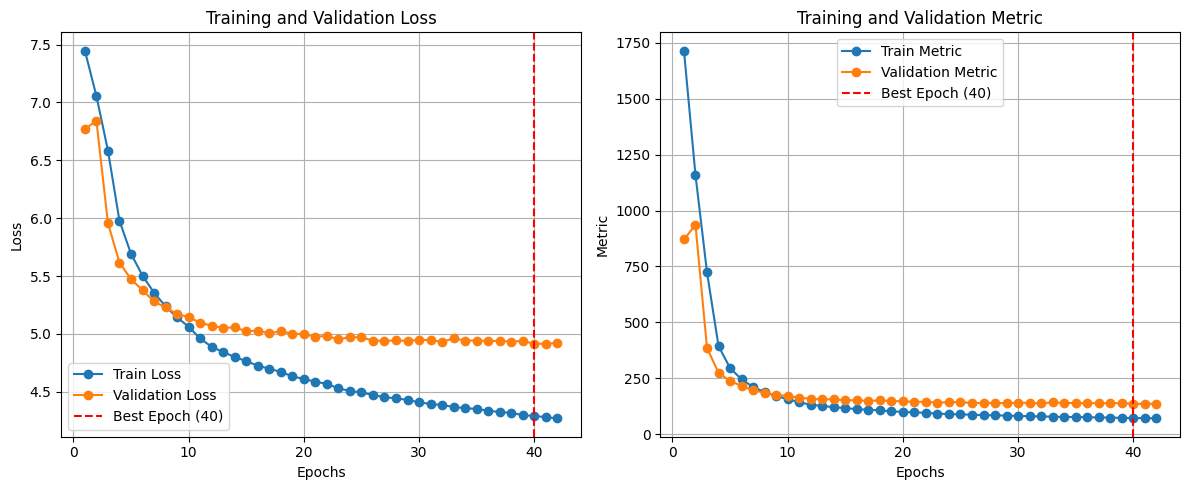

In [93]:
plot_training_history(loss_train_hist, loss_valid_hist, metric_train_hist, metric_valid_hist)

## 🟠 Main Loop

🔰 Define model.

In [31]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)

🔰 Define optimizer and Set learning rate and weight decay.

In [95]:
lr = 5e-3
wd = 1e-5
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

🔰 Write code to train the model for `num_epochs` epoches.

In [33]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [36]:
num_epochs = 10

for epoch in range(num_epochs):
    # Train
    model, loss_train, metric_train = train(model, train_dataset, 
                                            loss_fn, optimizer, metric, device)    
    # Validation
    loss_valid, metric_valid = evaluate(model, valid_dataset, loss_fn, metric)
    
    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)
    
    metric_train_hist.append(metric_train)
    metric_valid_hist.append(metric_valid)
    
    if loss_valid < best_loss_valid:
        torch.save(model, f'model.pt')
        best_loss_valid = loss_valid
        print('Model Saved!')

    print(f'epoch:{epoch+1}\nTrain: Loss = {loss_train:.4}, Metric = {metric_train:.4}')
    print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
    print()
    
    epoch_counter += 1

Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.19it/s]


Model Saved!
epoch:1
Train: Loss = 3.949, Metric = 51.89
Valid: Loss = 4.366, Metric = 78.69



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.18it/s]


Model Saved!
epoch:2
Train: Loss = 3.945, Metric = 51.65
Valid: Loss = 4.365, Metric = 78.67



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.18it/s]


epoch:3
Train: Loss = 3.94, Metric = 51.39
Valid: Loss = 4.366, Metric = 78.71



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.19it/s]


Model Saved!
epoch:4
Train: Loss = 3.936, Metric = 51.22
Valid: Loss = 4.365, Metric = 78.63



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Model Saved!
epoch:5
Train: Loss = 3.932, Metric = 51.02
Valid: Loss = 4.365, Metric = 78.63



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.19it/s]


epoch:6
Train: Loss = 3.93, Metric = 50.92
Valid: Loss = 4.365, Metric = 78.64



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.17it/s]


Model Saved!
epoch:7
Train: Loss = 3.925, Metric = 50.66
Valid: Loss = 4.363, Metric = 78.47



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.16it/s]


epoch:8
Train: Loss = 3.922, Metric = 50.53
Valid: Loss = 4.364, Metric = 78.59



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.16it/s]


epoch:9
Train: Loss = 3.922, Metric = 50.49
Valid: Loss = 4.365, Metric = 78.62



Evaluating: 100%|██████████| 17/17 [00:02<00:00,  6.20it/s]


Model Saved!
epoch:10
Train: Loss = 3.918, Metric = 50.31
Valid: Loss = 4.363, Metric = 78.47



## 🟠 Plot

🔰 Plot learning curves

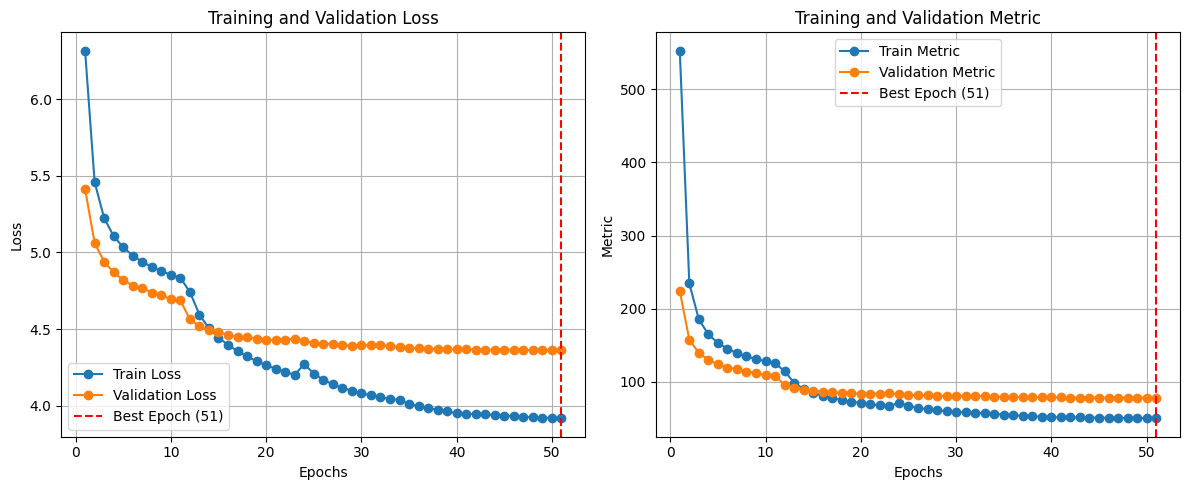

In [39]:
plot_training_history(loss_train_hist, loss_valid_hist, metric_train_hist, metric_valid_hist)

# 🔴 **Test**

🔰 Test your model using data from the test set

In [40]:
loss_test, metric_test = evaluate(model, test_dataset, loss_fn, metric)
print(f'Test: Loss = {loss_test:.4}, Metric = {metric_test:.4}')

Evaluating: 100%|██████████| 20/20 [00:03<00:00,  6.33it/s]

Test: Loss = 4.316, Metric = 74.9


# 🔴 **Generate**

🔰 Your mission is to write a `generate` function and use a desired sentence to evaluate the model

In [ ]:
model = LSTM(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate, tie_weights).to(device)

In [9]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

LSTM(
  (embedding): Embedding(20923, 1024)
  (lstm): LSTM(1024, 1024, num_layers=2, batch_first=True, dropout=0.65)
  (dropout): Dropout(p=0.65, inplace=False)
  (fc): Linear(in_features=1024, out_features=20923, bias=True)
)

In [42]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  
            prediction = torch.multinomial(probs, num_samples=1).item()    
            
            while prediction == vocab['<unk>']:
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['<eos>']:
                break

            indices.append(prediction)

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [77]:
max_seq_len = 50
prompts = [('that son in her life is', 50),
           ('Former team captains Travis', 36),
           ("the united states", 42),
           ("best character", 42)
          ]
for prompt, seed in prompts:
    temperatures = [0.5, 0.7, 0.75, 0.8, 1, 1.2, 1.5]
    for temperature in temperatures:
        generation = generate(prompt, max_seq_len, temperature, model, tokenizer, 
                              vocab, device, seed)
        print(str(temperature)+':\t'+' '.join(generation))
    print("=="*80)

0.5:	that son in her life is featured in the english film .
0.7:	that son in her life is featured in the english production .
0.75:	that son in her life is featured in the english production .
0.8:	that son in her life is featured in a midnight by an ex @-@ police officer . after why the people took a compromise , she is unable to prevent her .
1:	that son in her life is featured as sad . although both lady edward has changed and the poem why not to be a authority that is no longer water than a easy source , it is widely regarded as based upon physical issues .
1.2:	that son in her life is featured as sad the shoulder by allan edward max and the crawford why afterwards .
1.5:	that son in her life is featured as sad the shoulder by allan edward would establishments and groundwater him why afterwards sticks in a few wilhelmshaven flows from beneath water . liberated by there , kit siberia is pinned lie ahead of physical mash . before fires at how the film sovereignty to fire lifting gold